In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
#import sklearn.linear_model as lm   # for linear regression

### Leer datos

In [31]:
data = pd.read_csv('./data/train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [32]:
data.isnull().sum() / data.shape[0] * 100

Id                0.000000
MSSubClass        0.000000
MSZoning          0.000000
LotFrontage      17.739726
LotArea           0.000000
                   ...    
MoSold            0.000000
YrSold            0.000000
SaleType          0.000000
SaleCondition     0.000000
SalePrice         0.000000
Length: 81, dtype: float64

In [33]:
print(f"total datos en el dataset: {data.shape[0]}")

total datos en el dataset: 1460


In [34]:
#filtrar datos para salecondition = normal

data_filter_normal_sale = data[data['SaleCondition'] == 'Normal']

In [35]:
print(f"total datos en el dataset filtrado: {data_filter_normal_sale.shape[0]}")

total datos en el dataset filtrado: 1198


### Contexto

Transacciones como WD y CWD suelen representar ventas convencionales, lo que las hace útiles como referencia para estimar precios de mercado.<br>
VWD, Con, y sus variaciones pueden tener precios ajustados según los términos del financiamiento.

Con (Contract 15% Down payment regular terms):<br>
Venta bajo contrato donde el comprador realiza un pago inicial del 15% y se acuerdan términos regulares para el resto del financiamiento.<br>

WD (Warranty Deed - Conventional):<br>
Venta convencional con una escritura de garantía. Este es un tipo estándar de transferencia de propiedad donde el vendedor garantiza que tiene un título claro y que protegerá al comprador contra reclamaciones futuras.<br>

CWD (Warranty Deed - Cash):<br>
Venta con escritura de garantía, pero realizada completamente en efectivo, sin financiación o hipoteca involucrada.<br>

VWD (Warranty Deed - VA Loan):<br>
Venta con escritura de garantía financiada mediante un préstamo respaldado por el Departamento de Asuntos de Veteranos (VA). Este tipo de financiamiento generalmente está disponible para militares, veteranos y sus familias.<br>

##### Otras consideraciones a tener en cuenta

ConLw (Contract Low Down payment and low interest):<br>
Venta bajo contrato con un pago inicial bajo y tasas de interés reducidas. Este tipo de acuerdo puede atraer a compradores con menos capital inicial.<br>

ConLI (Contract Low Interest):<br>
Venta bajo contrato con tasas de interés bajas, lo que hace que los pagos sean más asequibles para el comprador.<br>

ConLD (Contract Low Down):<br>
Venta bajo contrato con un pago inicial bajo. Esto puede beneficiar a compradores que tienen recursos limitados para el pago inicial.<br>

In [36]:
# vamos a filtrar por wd, cwd y con

data_filter_normal_sale = data_filter_normal_sale[data_filter_normal_sale['SaleType'].isin(['WD', 'CWD', 'Con'])]

In [37]:
print(f"total datos en el dataset filtrado: {data_filter_normal_sale.shape[0]}")

total datos en el dataset filtrado: 1164


----

In [38]:
# transform Street to one hot encoding
#data_filter_normal_sale['Street'] = data_filter_normal_sale['Street'].map({'Grvl': 0, 'Pave': 1})

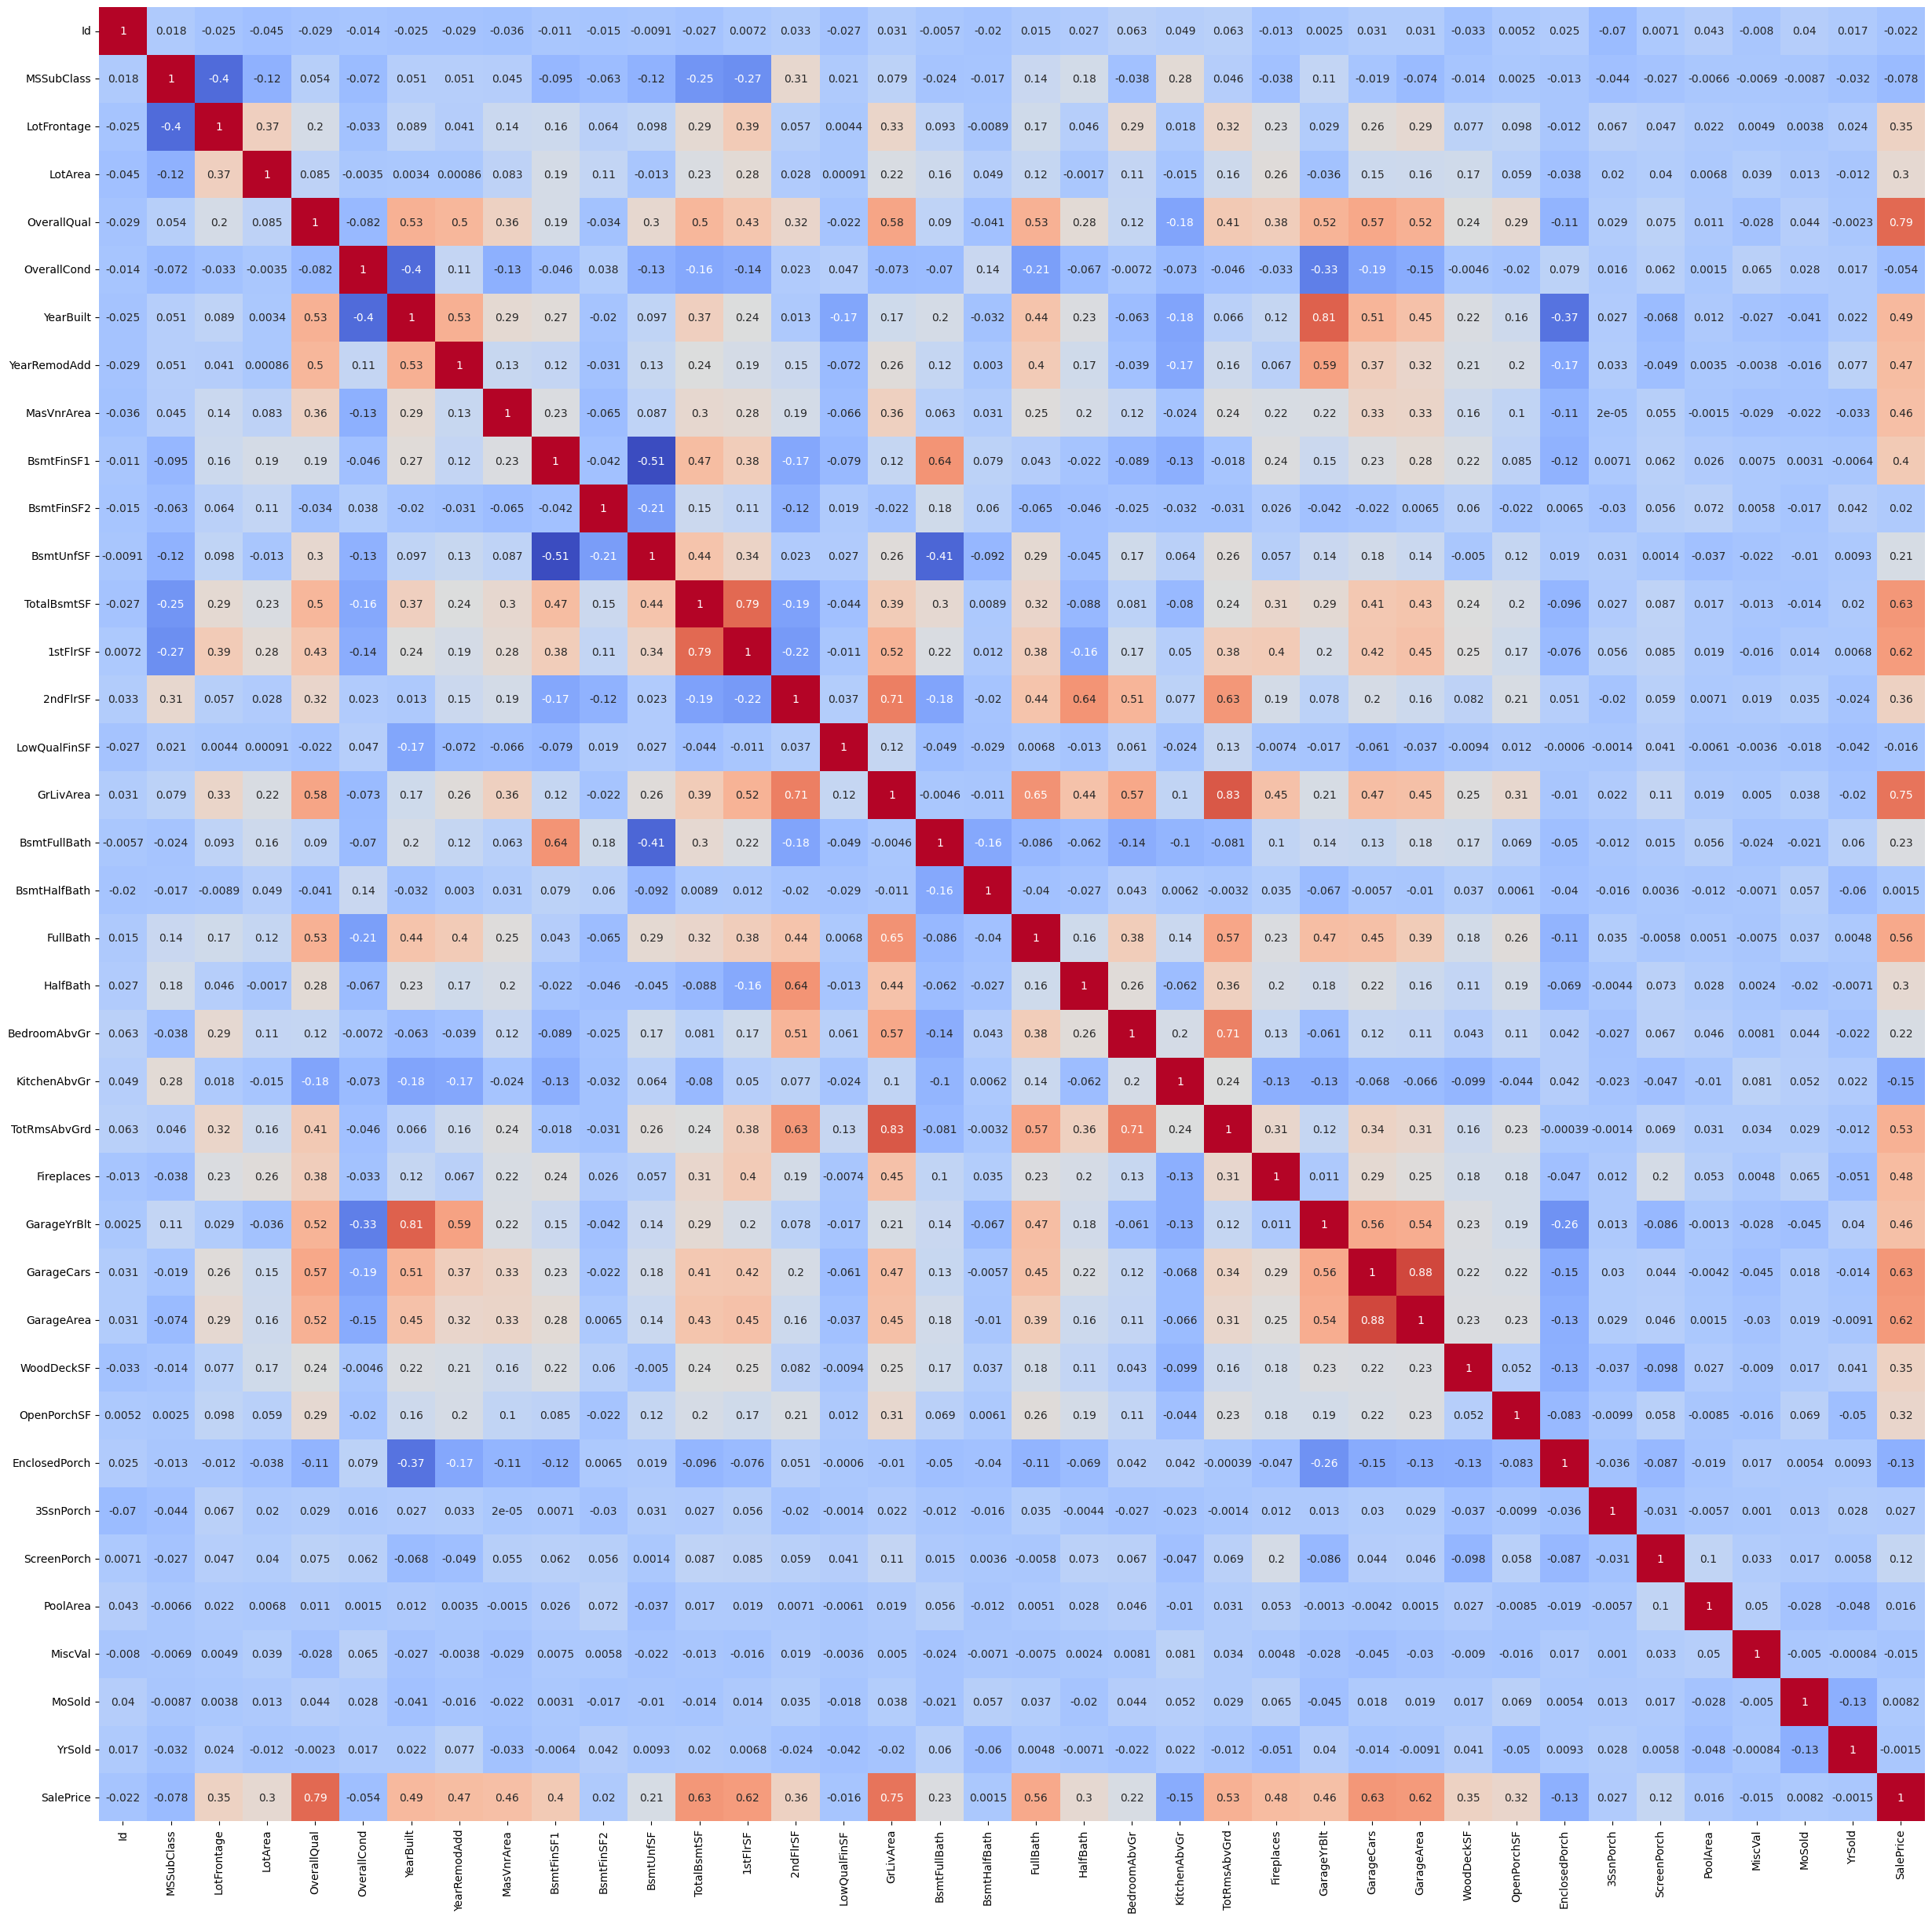

In [39]:
## Matriz de correlación
numeric_features = data_filter_normal_sale.select_dtypes(include=[np.number])
corr = numeric_features.corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=False)
plt.show()

In [44]:
## Escoger las variables que tienen mayor correlación con SalePrice
corr = corr['SalePrice']
corr = corr[np.argsort(corr, axis=0)[::-1]]
corr = corr[abs(corr) > 0.5]
corr

C:\Users\CristiamAlbertoLoaiz\AppData\Local\Temp\ipykernel_15016\2280767967.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  corr = corr[np.argsort(corr, axis=0)[::-1]]


SalePrice       1.000000
OverallQual     0.785390
GrLivArea       0.747230
TotalBsmtSF     0.634189
GarageCars      0.632343
GarageArea      0.618805
1stFlrSF        0.616766
FullBath        0.562583
TotRmsAbvGrd    0.528620
Name: SalePrice, dtype: float64

In [52]:
# Tomemos valores para entrenar el modelo
X = data_filter_normal_sale[['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']]
y = data_filter_normal_sale['SalePrice']

In [53]:
X.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
0,7,1710,2,548,856,856,2,8,2003,2003
1,6,1262,2,460,1262,1262,2,6,1976,1976
2,7,1786,2,608,920,920,2,6,2001,2002
4,8,2198,3,836,1145,1145,2,9,2000,2000
5,5,1362,2,480,796,796,1,5,1993,1995


In [73]:
y

0       208500
1       181500
2       223500
4       250000
5       143000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1164, dtype: int64

no revise nulos - falla

In [70]:
X.isnull().sum()

OverallQual     0
GrLivArea       0
GarageCars      0
GarageArea      0
TotalBsmtSF     0
1stFlrSF        0
FullBath        0
TotRmsAbvGrd    0
YearBuilt       0
YearRemodAdd    0
dtype: int64

### Separemos datos de entrenamiento y testeo

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=42)

### Usemos libreria de entrenamiento

In [55]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [56]:
# Predicciones
y_pred = model.predict(X_test)


### Revismos la calidad del modelo

In [58]:
# Evaluación del modelo
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 744356641.0132564


In [71]:
np.sqrt(mse)

np.float64(27282.90015766756)

In [59]:
# miremos R2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R2: {r2}")


R2: 0.8390486857256408


### Despliegue del modelo

Text(0.5, 1.0, 'True Price vs Predicted Price')

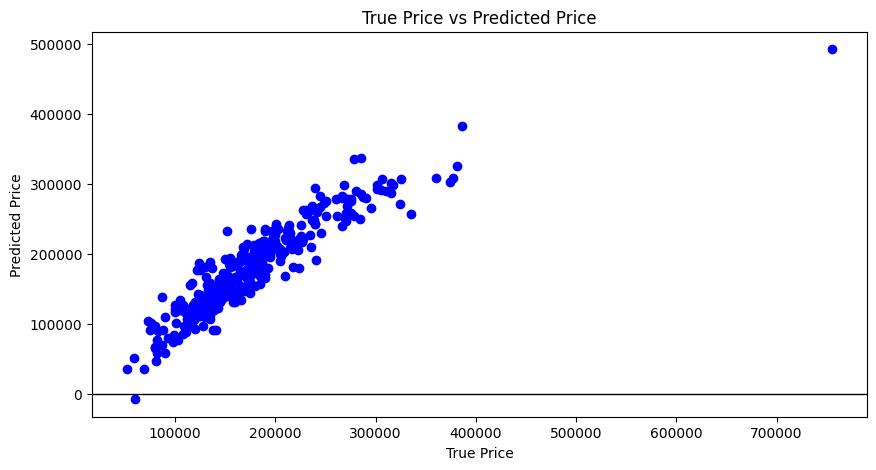

In [63]:
## Graficar los resultados
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, color='blue')
plt.xlabel('True Price')
plt.ylabel('Predicted Price')
plt.title('True Price vs Predicted Price')


Text(0.5, 1.0, 'Predicted Price vs Residuals')

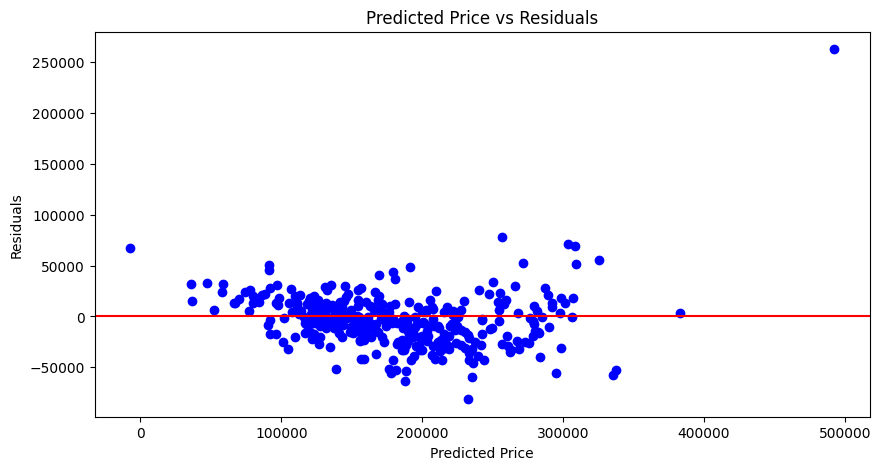

In [62]:
## Graficar los residuales
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Predicted Price vs Residuals')


In [65]:
# llevemos el modelo a produccion
import pickle
pickle.dump(model, open('model.pkl', 'wb'))
print("Modelo guardado en model.pkl")


Modelo guardado en model.pkl


----

# Leamos el modelo

In [69]:
# leamos modelo
model = pickle.load(open('model.pkl', 'rb'))
print("Modelo leído de model.pkl")
# hagamos una predicción
#lista = [1,2,3,4,45]
print(f"Prediccion modelo valor vivienda {model.predict([X_test.iloc[0]])[0]}")


Modelo leído de model.pkl
OverallQual        6
GrLivArea        918
GarageCars         1
GarageArea       264
TotalBsmtSF      918
1stFlrSF         918
FullBath           2
TotRmsAbvGrd       5
YearBuilt       1979
YearRemodAdd    1979
Name: 972, dtype: int64
Prediccion modelo valor vivienda 122079.68097547465


c:\Users\CristiamAlbertoLoaiz\Documents\repositories_git\python-basics\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
